# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at mlta-2023-spring@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [5]:
# !apt update
# !apt install python-opengl xvfb -y
!pip install -q swig
!pip install box2d==2.3.2 gym[box2d]==0.25.2 box2d-py pyvirtualdisplay tqdm numpy==1.22.4
!pip install box2d==2.3.2 box2d-kengz
!pip freeze > requirements.txt


  Using cached gym-0.25.2.tar.gz (734 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.22.4.zip (11.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      
      
      WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
      Using UNIX configuration...
      
      
      Hunting dependencies...
      /bin/sh: 1: sdl2-config: not found
      /bin/sh: 1: sdl2-config: not found
      /bin/sh: 1: sdl2-config: not found
      
      ---
      For help with compilatio


Next, set up virtual display，and import all necessaary packages.

In [6]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [7]:
seed = 2023 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [8]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

DependencyNotInstalled: pygame is not installed, run `pip install gym[box2d]`

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment".

In this homework, we will utilize the function `step()` to control the action of "Agent".

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [ ]:
print(env.observation_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [ ]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment.
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [ ]:
initial_state = env.reset()
print(initial_state)

[-0.00506535  1.413064   -0.5130838   0.09527162  0.00587628  0.11622101
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [ ]:
random_action = env.action_space.sample()
print(random_action)

1


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [ ]:
observation, reward, done, info = env.step(random_action)

In [ ]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.

In [ ]:
print(reward)

-1.4981841929643156


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

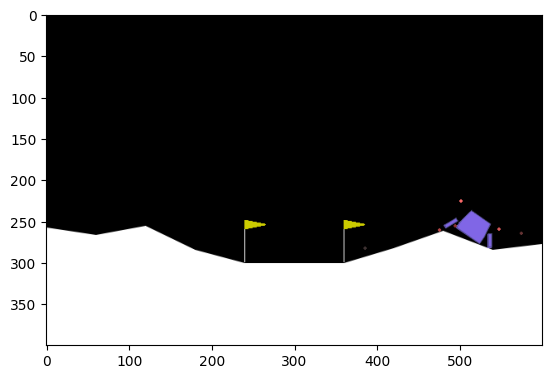

In [ ]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [ ]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(hid)
        return F.softmax(self.fc3(hid), dim=-1)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.

In [ ]:
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.02)

    def forward(self, state):
        return self.network(state)

    # def learn(self, log_probs, rewards):
    #     loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

    #     self.optimizer.zero_grad()
    #     loss.backward()
    #     self.optimizer.step()

    def learn(self, log_probs, rewards, state_values):
        # Calculate the advantages
        advantages = rewards - state_values.detach()

        # Compute loss
        loss = (-log_probs * advantages).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

Lastly, build a network and agent to start training.

In [ ]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## Critic

In [ ]:
class Critic(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)  # Note: output size is 1 because the critic estimates a value, not a probability distribution.

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return self.fc3(hid)  # Note: No softmax here. The critic is estimating a value, not a probability distribution.


critic = Critic()

def critic_loss(value, reward):
    # Convert rewards to FloatTensor
    reward = reward.float()
    value = value.squeeze(-1)

    # Mean Squared Error Loss for critic
    return F.mse_loss(value, reward)


critic_optimizer = torch.optim.Adam(critic.parameters(), lr=0.02)

## ActorCritic

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.affine = nn.Linear(8, 128)

        self.action_layer = nn.Linear(128, 4)
        self.value_layer = nn.Linear(128, 1)

        # self.action_layer = nn.Sequential(
        #     nn.Linear(8, 16),
        #     nn.ReLU(),
        #     nn.Linear(16, 16),
        #     nn.ReLU(),
        #     nn.Linear(16, 4)
        # )

        # self.value_layer = nn.Sequential(
        #     nn.Linear(8, 16),
        #     nn.ReLU(),
        #     nn.Linear(16, 16),
        #     nn.ReLU(),
        #     nn.Linear(16, 1)
        # )

        self.logprobs = []
        self.state_values = []
        self.rewards = []

    # def forward(self, state):
    #     state = torch.from_numpy(state).float()
    #     # state = F.relu(self.affine(state))

    #     state_value = self.value_layer(state)

    #     action_probs = F.softmax(self.action_layer(state))
    #     action_distribution = Categorical(action_probs)
    #     action = action_distribution.sample()

    #     self.logprobs.append(action_distribution.log_prob(action))
    #     self.state_values.append(state_value)

    #     return action.item()

    def forward(self, state):
        state = torch.from_numpy(state).float()
        state = F.relu(self.affine(state))
        state_value = self.value_layer(state)

        action_probs = F.softmax(self.action_layer(state))
        action_distribution = Categorical(action_probs)
        action = action_distribution.sample()

        log_prob = action_distribution.log_prob(action)
        return action.item(), log_prob, state_value


    def calculateLoss(self, gamma=0.99):

        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.append(dis_reward)
        rewards = rewards[::-1]

        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())

        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)
        return loss

    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Training Agent new

In [ ]:

agent = ActorCritic()

agent.train()  # Switch network into training mode
EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
NUM_BATCH = 2000        # totally update the agent for 500 time
GAMMA = 0.99
BETAS = (0.9, 0.99)
LR =0.02

optimizer = optim.Adam(agent.parameters(), lr=LR, betas=BETAS)



avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards, values = [], [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):

        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        # for t in range(10000):
        while True:

            # action = agent(state) # at, log(at|st)
            action, log_prob, state_value = agent(state)
            next_state, reward, done, _ = env.step(action)

            agent.logprobs.append(log_prob)
            agent.state_values.append(state_value)
            agent.rewards.append(reward)

            state = next_state
            total_reward += reward
            total_step += 1

            if done:

                final_rewards.append(reward)
                total_rewards.append(total_reward)

                break

    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # Updating the policy :
    optimizer.zero_grad()
    loss = agent.calculateLoss(GAMMA)
    loss.backward()
    optimizer.step()
    agent.clearMemory()

  0%|          | 0/2000 [00:00<?, ?it/s]

<ipython-input-226-d2f01ef56b25>:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_probs = F.softmax(self.action_layer(state))
<ipython-input-226-d2f01ef56b25>:75: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [ ]:
# agent.network.train()  # Switch network into training mode
# EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
# NUM_BATCH = 2000        # totally update the agent for 500 time
# GAMMA = 0.99

# avg_total_rewards, avg_final_rewards = [], []

# prg_bar = tqdm(range(NUM_BATCH))
# for batch in prg_bar:

#     log_probs, rewards, values = [], [], []
#     total_rewards, final_rewards = [], []

#     # collect trajectory
#     for episode in range(EPISODE_PER_BATCH):

#         state = env.reset()
#         total_reward, total_step = 0, 0
#         seq_rewards = []
#         while True:

#             action, log_prob = agent.sample(state) # at, log(at|st)
#             next_state, reward, done, _ = env.step(action)

#             value = critic(torch.tensor(state))
#             values.append(value)

#             log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
#             seq_rewards.append(reward)
#             state = next_state
#             total_reward += reward
#             total_step += 1
#             # rewards.append(reward) # change here
#             # ! IMPORTANT !
#             # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
#             #                                                         rewards :     r1, r2 ,r3 ......
#             # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
#             #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
#             # boss : implement Actor-Critic
#             if done:
#                 # Calculate discounted rewards
#                 discounted_rewards = []
#                 future_reward = 0
#                 for reward in seq_rewards[::-1]:
#                     future_reward = reward + GAMMA * future_reward
#                     discounted_rewards.insert(0, future_reward)
#                 # Append to rewards list
#                 rewards.extend(discounted_rewards)

#                 final_rewards.append(reward)
#                 total_rewards.append(total_reward)

#                 break

#     print(f"rewards looks like ", np.shape(rewards))
#     #print(f"log_probs looks like ", np.shape(log_probs))
#     # record training process
#     avg_total_reward = sum(total_rewards) / len(total_rewards)
#     avg_final_reward = sum(final_rewards) / len(final_rewards)
#     avg_total_rewards.append(avg_total_reward)
#     avg_final_rewards.append(avg_final_reward)
#     prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

#     # rewards = np.concatenate(rewards, axis=0)
#     rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward

#     # Update the critic
#     critic_optimizer.zero_grad()
#     loss = critic_loss(torch.stack(values), torch.from_numpy(rewards))
#     loss.backward()
#     critic_optimizer.step()

#     # update agent
#     # agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
#     agent.learn(torch.stack(log_probs), torch.from_numpy(rewards), torch.stack(values))
#     print("logs prob looks like ", torch.stack(log_probs).size())
#     print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:


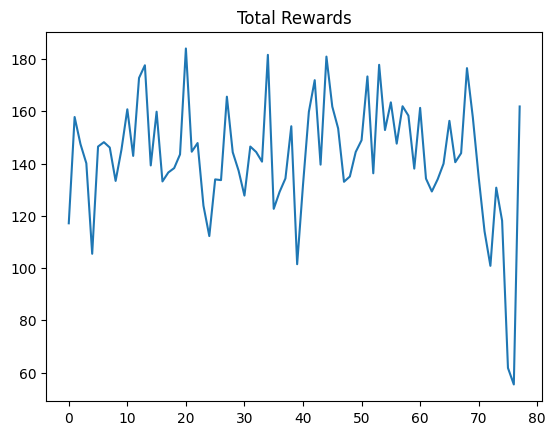

In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


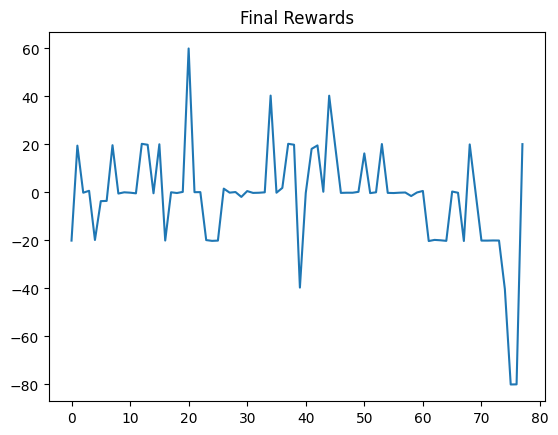

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

-5.39206029924901


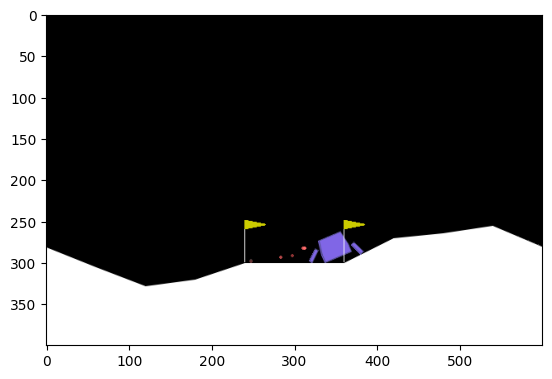

In [ ]:
fix(env, seed)
# agent.network.eval()  # set the network into evaluation mode
agent.eval()  # set the network into evaluation mode
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      # action, _ = agent.sample(state)
      action,_,_ = agent(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)

  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing


In [ ]:
print(np.mean(test_total_reward))

68.81081984552125


Action list

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 1, 1, 2, 3, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 3, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 2, 0, 3, 1, 3, 2, 3, 3, 1, 3, 2, 3, 3, 3, 1, 1, 0, 3, 2, 3, 2, 1, 2, 2, 2, 2, 3, 3, 1, 2, 3, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 

Analysis of actions taken by agent

In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{3: 230, 0: 18, 1: 132, 2: 329}


Saving the result of Model Testing


In [ ]:
PATH = "Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list))

<ipython-input-221-fd322f3df017>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(PATH ,np.array(action_list))


### This is the file you need to submit !!!
Download the testing result to your device



In [ ]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Server
The code below simulate the environment on the judge server. Can be used for testing.

Your reward is : 215.85
Your reward is : -460.47
Your reward is : -296.97
Your reward is : -353.56
Your reward is : -252.43


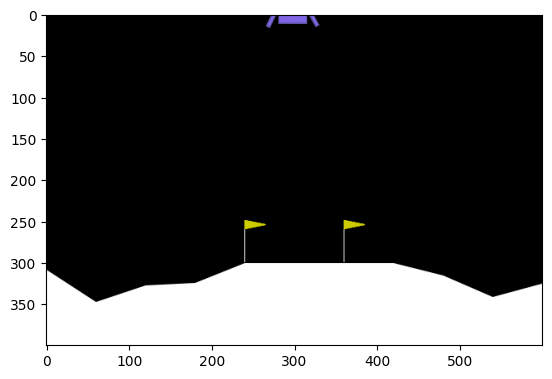

In [ ]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 2023 # Do not revise this
fix(env, seed)

agent.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:

      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : -229.52


## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
